In [44]:
from traffic.core import Traffic
from preprocessing import get_complete_flights, preprocess_traffic, generate_aux_columns, seconds_till_arrival
import h5py
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import itertools
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

In [6]:
scaler = load('../trained_models/std_scaler_reg.bin')
file_0 = "../data/Frankfurt_LH_2301.h5"
file_1 = "Frankfurt_LH_2302.h5"
file_batch = [file_0 ,file_1]


In [7]:
def load_data_batch(file_batch, sample_fraction=1):
    first_day = True
    for file in file_batch:
        with h5py.File(file, 'r') as f:
            for key in tqdm(list(f.keys()),desc=file):

                new_flights = Traffic.from_file(file, key=key,
                                                parse_dates=["day", "firstseen", "hour", "last_position",
                                                             "lastseen", "timestamp"]).data

                if first_day:
                    df_flights = preprocess_traffic(new_flights)
                    df_flights = df_flights[
                        [
                            "distance",
                            "altitude",
                            "geoaltitude",
                            "arrival_time",
                            "timestamp",
                            "vertical_rate",
                            "groundspeed",
                        ]
                    ].dropna()
                    df_flights = df_flights.sample(frac=sample_fraction)
                    first_day = False
                else:
                    old_flights = pd.concat([old_flights,new_flights])
                    start = new_flights.day.min().replace(tzinfo=None)
                    end = start + datetime.timedelta(days=1)
                    relevant_time = [str(start), str(end)]
                    df_add_flights = preprocess_traffic(old_flights, relevant_time)
                    df_add_flights = df_add_flights[
                        [
                            "distance",
                            "altitude",
                            "geoaltitude",
                            "arrival_time",
                            "timestamp",
                            "vertical_rate",
                            "groundspeed",
                        ]
                    ].dropna()
                    del(old_flights)
                    df_add_flights = df_add_flights.sample(frac=sample_fraction)
                    df_flights = pd.concat([df_flights, df_add_flights])
                    del(df_add_flights)
                old_flights = new_flights


    return df_flights

In [61]:
model_file = '../trained_models/model_very_thin_dropout'
model = load_model(model_file)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              18432     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1

In [9]:
df_eval = load_data_batch(file_batch, sample_fraction= 0.001)
df_eval = generate_aux_columns(df_eval)

../data/Frankfurt_LH_2301.h5:   0%|          | 0/30 [00:00<?, ?it/s]

Frankfurt_LH_2302.h5:   0%|          | 0/18 [00:00<?, ?it/s]

In [41]:
y = seconds_till_arrival(df_eval)
X = df_eval.drop(columns=["arrival_time", "timestamp"])
cols_numeric = ["distance", "altitude", "geoaltitude", "vertical_rate","groundspeed"]
X_numeric = X[cols_numeric]
distances_to_airport = df_eval.distance.values
X[cols_numeric] = scaler.transform(X_numeric)

In [62]:
predictions = model.predict(X)

1237/1237 [==============================] - 6s 5ms/step


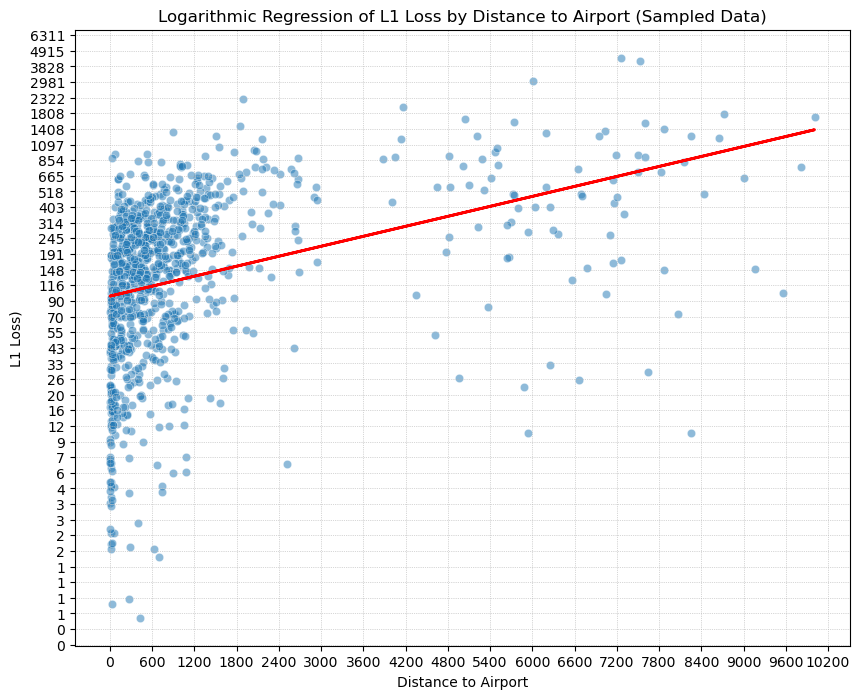

In [63]:
actual_arrival_times = y.values
losses = np.abs(actual_arrival_times - predictions.reshape(-1))

sample_size = 1000
# Randomly select a subset of data points
indices = np.random.choice(len(losses), size=sample_size, replace=False)
sampled_distances = distances_to_airport[indices]
sampled_losses = losses[indices]

# Take the logarithm of the y-values
log_losses = np.log(sampled_losses)

# Perform linear regression on the transformed data
coefficients = np.polyfit(sampled_distances, log_losses, 1)
linear_fit = np.poly1d(coefficients)
log_y = linear_fit(sampled_distances)

# Create a scatter plot with the logarithmic regression line using the transformed data
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x=sampled_distances, y=log_losses, alpha=0.5, ax=ax)
plt.plot(sampled_distances, log_y, color='red', linewidth=2)
plt.xlabel('Distance to Airport')
plt.ylabel('L1 Loss)')
plt.title('Logarithmic Regression of L1 Loss by Distance to Airport (Sampled Data)')

# Format the y-axis ticks to display the actual values
def y_tick_formatter(value, pos):
    return f'{np.exp(value):.0f}'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_tick_formatter))

# Customize the y-axis grid
num_y_ticks = 40  # Number of ticks on the y-axis
y_grid_locator = ticker.MaxNLocator(nbins=num_y_ticks)
ax.yaxis.set_major_locator(y_grid_locator)

# Customize the x-axis grid
num_x_ticks = 20  # Number of ticks on the x-axis
x_grid_locator = ticker.MaxNLocator(nbins=num_x_ticks)
ax.xaxis.set_major_locator(x_grid_locator)

ax.grid(True, which='both', linestyle='dotted', linewidth=0.5)

plt.show()


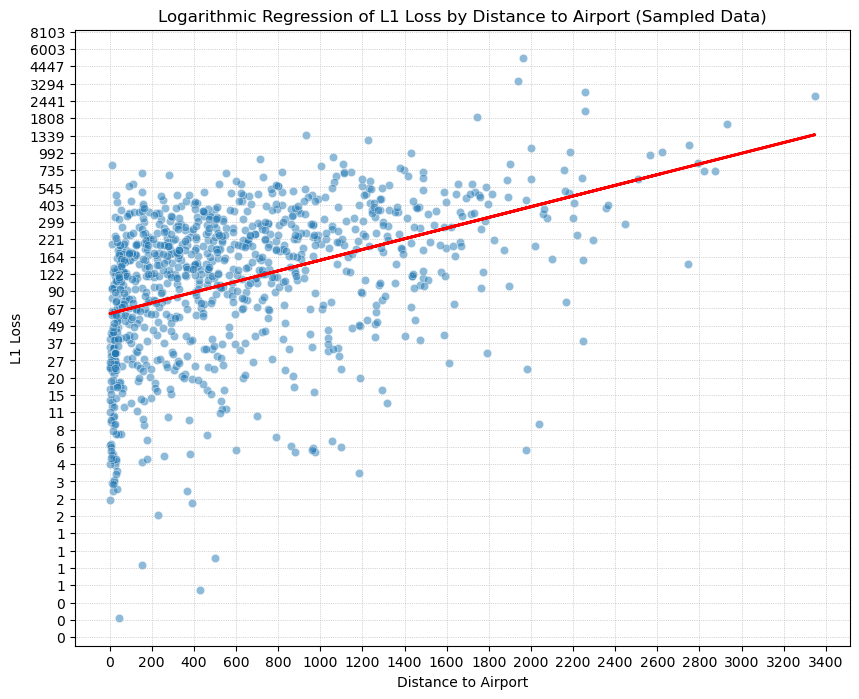

In [64]:
actual_arrival_times = y.values
losses = np.abs(actual_arrival_times - predictions.reshape(-1))
sample_size = 1000
# Filter the data based on the distance to the airport
filtered_indices = np.where(distances_to_airport < 3600)
filtered_distances = distances_to_airport[filtered_indices]
filtered_losses = losses[filtered_indices]

# Randomly select a subset of filtered data points
sample_indices = np.random.choice(len(filtered_distances), size=sample_size, replace=False)
sampled_distances = filtered_distances[sample_indices]
sampled_losses = filtered_losses[sample_indices]

# Take the logarithm of the y-values
log_losses = np.log(sampled_losses)

# Perform linear regression on the transformed data
coefficients = np.polyfit(sampled_distances, log_losses, 1)
linear_fit = np.poly1d(coefficients)
log_y = linear_fit(sampled_distances)

# Create a scatter plot with the logarithmic regression line using the transformed data
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x=sampled_distances, y=log_losses, alpha=0.5, ax=ax)
plt.plot(sampled_distances, log_y, color='red', linewidth=2)
plt.xlabel('Distance to Airport')
plt.ylabel('L1 Loss')  # Updated y-label
plt.title('Logarithmic Regression of L1 Loss by Distance to Airport (Sampled Data)')

# Format the y-axis ticks to display the actual values
def y_tick_formatter(value, pos):
    return f'{np.exp(value):.0f}'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_tick_formatter))

# Customize the y-axis grid
num_y_ticks = 40  # Number of ticks on the y-axis (doubled)
y_grid_locator = ticker.MaxNLocator(nbins=num_y_ticks)
ax.yaxis.set_major_locator(y_grid_locator)

# Customize the x-axis grid
num_x_ticks = 20  # Number of ticks on the x-axis
x_grid_locator = ticker.MaxNLocator(nbins=num_x_ticks)
ax.xaxis.set_major_locator(x_grid_locator)

ax.grid(True, which='both', linestyle='dotted', linewidth=0.5)

plt.show()